# Week 5: RDKit (part 1)

RDKit is an open-source cheminformatics toolkit. We will go through some of the most useful RDKit functionalities: 
1. Reading and writing
2. Descriptors
3. Fingerprints

## Reading and writing 

There are many ways to represent chemical structures. As chemists, we are familiar with IUPAC names and line drawings. As cheminformaticists, we need representations that work with computers. Some common text-based representations include SMILES (Simplified Molecular Input Line Entry System), a variant on SMILES called SELFIES (Self-Referencing Embedded Strings), and InChi (International Chemical Identifier). 

Let's make our first molecule from smiles.

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

ethanol = Chem.MolFromSmiles("CCO") # Ethanol
print(ethanol)

rdkit is built around this Mol object. We can see the structure as follows: 

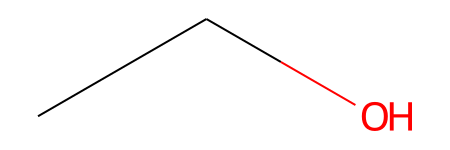

In [4]:
ethanol

### SMILES crash course


In chemical structures represented by SMILES notation:

- Atoms are denoted by their atomic symbols.
- Bonds between adjacent atoms are typically single unless specified otherwise (double bonds are indicated by '=', triple bonds by '#', and explicit single bonds by '-').
- Any unfilled valency is assumed to be filled with hydrogen atoms. For instance, "C" represents methane (CH4) and "O" represents water (H2O)
- Branches are encapsulated within parentheses. For example, (CC) represents an ethyl group.
- Rings are formed by breaking them at an arbitrary point and labeling atoms to indicate connectivity. For instance, C1CCCCC1 represents cyclohexane.
- Aromatic compounds can be depicted explicitly (e.g., benzene as C1=CC=CC=C1) or with lowercase letters (e.g., c1ccccc1).

A nice introductory tutorial can be found here:
 https://chemicbook.com/2021/02/13/smiles-strings-explained-for-beginners-part-1.html

The daylight documentation can be found here: 
https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html


Experiment with smiles notation. Can you write the smiles for 1-butanol? Tert-butanol? As a challenge, write the smiles for vanillin. 

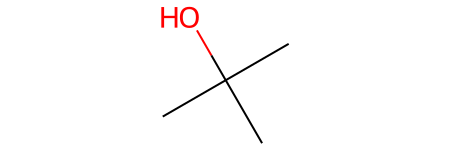

In [5]:
butanol = "CCCO"
tertbutanol = "CC(C)(C)O"
vanillin = "c1(O)c(OC)cc(C=O)cc1"

Chem.MolFromSmiles(tertbutanol)

The fact that multiple SMILES can represent the same molecule can cause confusion when you're trying to search a database. To deal with this, RDKit provides a canonicalization function, which ensures that chemically equivalent molecules are represented consistently. Note that canonicalizaiton depends on the exact implementation, so RDKit results may not be consistent with other packages.  

Given a list of three different smiles, convert each to a molecule using `Chem.MolFromSmiles()`, then convert back to smiles using `Chem.MolToSmiles()`. Count how many unique smiles there are. What does this indicate about the `Chem.MolToSmiles()` function? 

In [6]:
smiles_list = ["CC(=O)OC1=CC=CC=C1C(=O)O", "c1c(OC(=O)C)c(C(=O)O)ccc1", "CC(=O)Oc1ccccc1C(=O)O"] 

cannonical_smiles = []
for smiles in smiles_list: 
    mol = Chem.MolFromSmiles(smiles)
    cannonical_smiles.append(Chem.MolToSmiles(mol))

print("Number of unique canonical smiles: ", len(set(cannonical_smiles)))


Number of unique canonical smiles:  1


Thus far, we've only made molecules out of valid smiles. What happens when we put in a nonsense smiles, like "c1ccccc" which is missing the second number to indicate a ring closure. 

In [5]:
invalid_smiles = "c1ccccc" 
mol = Chem.MolFromSmiles(invalid_smiles)
print(mol)

None


[17:38:03] SMILES Parse Error: unclosed ring for input: 'c1ccccc'


However, some valid smiles may violate chemical rules. Take this smiles, which has a pentavalent carbon.

In [6]:
chemically_invalid = "C(C)(C)(C)(C)(C)"
mol = Chem.MolFromSmiles(chemically_invalid)
print(mol)


None


[10:12:34] Explicit valence for atom # 0 C, 5, is greater than permitted


We can choose to opt out of rdkit's chemical validity checks by using `sanitize = False`. This is normally not necessary, and should only be done with caution. 

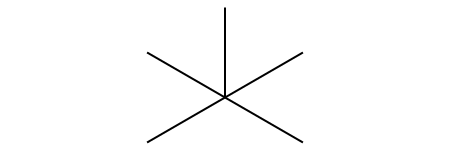

In [7]:
chemically_invalid = "C(C)(C)(C)(C)(C)"
mol = Chem.MolFromSmiles(chemically_invalid, sanitize = False)
print(mol)
mol

Note that when the molecule was invalid, it returned `None` instead of something like `<rdkit.Chem.rdchem.Mol object at 0x127c8bbc0>`. Rdkit also did its best to give us a helpful error on why it failed to make a molecule from that smiles. When handling many molecules at once, we should keep this in mind and do some error handling. 

Write a function called `canonicalize_smiles`. Make sure your function can handle invalid smiles with a helpful error message. 

In [8]:
def canonicalize_smiles(smiles: str) -> str:
    if not isinstance(smiles, str):
        raise TypeError(f"Invalid type {type(smiles)}: smiles must be a string")
    
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        raise ValueError(f"Could not convert smiles to mol")

    return Chem.MolToSmiles(mol)

Test your function on the following smiles:
1. 123
2. "CO(C)(C)(C)"
3. "CCO"
4. "OCC"

Does it behave as expected?

In [9]:
# Example
canonicalize_smiles("CO(C)(C)(C)")

[10:12:34] Explicit valence for atom # 1 O, 4, is greater than permitted


ValueError: Could not convert smiles to mol

We can use similar syntax to convert a mol object to and from other textual representations, like Inchi and InchiKey. 

InChI:  InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)
InChI Key:  BSYNRYMUTXBXSQ-UHFFFAOYSA-N


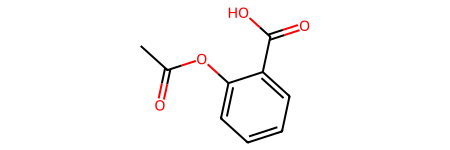

In [ ]:
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
aspirin = Chem.MolFromSmiles(aspirin_smiles)
print("InChI: ", Chem.MolToInchi(aspirin))
print("InChI Key: ", Chem.InchiToInchiKey(Chem.MolToInchi(aspirin)))

aspirin_inchi = "InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)"
aspirin = Chem.MolFromInchi(aspirin_inchi)
aspirin

Textual representations like smiles and Inchi have their uses. However, they cannot capture any of the 3D information that is crucial for so much chemistry. Other data formats have been devised, including SDF (e.g. the mol format). Rdkit lets us work with these too! Essentially, the SDF format encodes the coordinates of each atom, as well as the connectivity between atoms. More details can be found here: https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics/02%3A_Representing_Small_Molecules_on_Computers/2.05%3A_Structural_Data_Files

In [ ]:
aspirin_2d = Chem.MolToMolBlock(aspirin)
print("SDF format: ", aspirin_2d)

SDF format:  
     RDKit          2D

 13 13  0  0  0  0  0  0  0  0999 V2000
   -5.2500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0000   -2.5981    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    3.8971    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0000    2.5981    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0000    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  6  1  0

Notice how the third column of numbers is all 0.000. This molecule only has 2D coordinates. This is rdkit's default representation. However, rdkit enables us to come up with quite reasonable 3D coordinates based on the ETKDG method (more info available at https://www.rdkit.org/docs/GettingStartedInPython.html under the "Working with 3D molecules" section). 

In [ ]:
from rdkit.Chem import AllChem

aspirin_3d = Chem.AddHs(aspirin)
AllChem.EmbedMolecule(aspirin_3d)
print(Chem.MolToMolBlock(aspirin_3d))


     RDKit          3D

 21 21  0  0  0  0  0  0  0  0999 V2000
    3.4335    0.4147    0.0589 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7894   -1.2937   -0.2256 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8070   -2.1660   -0.6363 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5188    0.0357    0.0259 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5155   -1.7119   -0.8043 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0338   -0.0218    0.2716 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2251    0.4674   -0.1478 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2294   -0.3889   -0.5576 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8951    1.8546    0.1045 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6659   -0.4450    1.3963 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8057    2.6308    0.4777 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.3943    2.3419   -0.0553 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.0896    0.0179   -0.7425 O   0  0  0  0  0  0  0  0  0  0  0  0
    4.0887   -0.4855    0

Up until now, we've been working with chunks of text. We might want to read from files directly. Rdkit makes this easy!

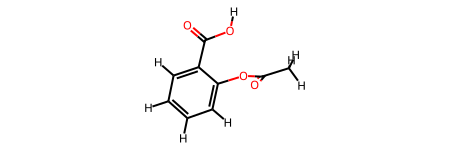

In [ ]:
aspirin_3d

In [ ]:
# Write to a mol file
Chem.MolToMolFile(aspirin_3d, "aspirin.mol")

In [ ]:
# Alternative write
with open("aspirin.mol", "w") as file:
    file.write(Chem.MolToMolBlock(aspirin_3d))

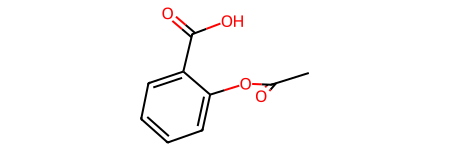

In [ ]:
# Read from a mol file 
Chem.MolFromMolFile("aspirin.mol")

In [ ]:
# Alternative read
with open("aspirin.mol", "r") as file:
     mol_block = file.read()
     aspirin_mol = Chem.MolFromMolBlock(mol_block)

The default rdkit behavior is to show the molecule with implicit hydrogens. We can change this behavior if we want to. 

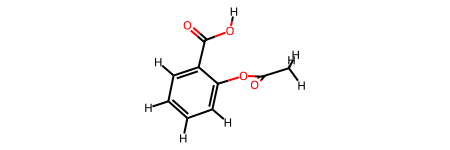

In [ ]:
Chem.MolFromMolFile("aspirin.mol", removeHs = False)

Rdkit's 3D rendering abilitiy leaves something to be desired. To better understand the 3D structure of our molecule, we can use a convenient library called py3Dmol. 

In [ ]:
#!pip install py3Dmol

In [ ]:
import py3Dmol

# Helpful function from a blog (https://rdkit.blogspot.com/2016/07/a-recent-post-on-in-pipeline-talked.html)
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

drawit(aspirin_3d)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Working with Mol objects

Rdkit's mol objects are an intuitive way to store chemical information. Just like we think of molecules as a collection of atoms and a collection of bonds, an rdkit mol object is composed of atom objects and bond objects. 

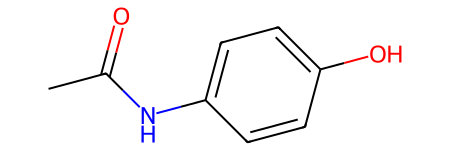

In [ ]:
tylenol_smiles = "CC(=O)NC1=CC=C(C=C1)O"
tylenol = Chem.MolFromSmiles(tylenol_smiles)
tylenol 

How many atoms are there in tylenol? Bonds? 

In [ ]:
print("Number of atoms: ", tylenol.GetNumAtoms())
print("Number of bonds: ", tylenol.GetNumBonds())

Number of atoms:  11
Number of bonds:  11


You might be surprised to notice that rdkit only counts the number of heavy atoms (not H). 


In [ ]:
print("Number of atoms: ", tylenol.GetNumAtoms(onlyExplicit = False))
print("Number of bonds: ", tylenol.GetNumBonds(onlyHeavy = False))

Number of atoms:  20
Number of bonds:  20


To get the atom or bond objects from an rdkit mol object, we can use the `mol.GetAtoms()` or `mol.GetBonds()` methods.

In [ ]:
print(tylenol.GetAtoms())
print(tylenol.GetBonds())

These yield iterators. We can access individual atoms using with for loops. Each atom and bond holds a lot of information. 

Taking inspiration from the lecture, print the symbol, atomic number, index, degree, valence, and hybridization of each atomn in tylenol. 

In [ ]:
for atom in tylenol.GetAtoms():
    print(f"Atom: {atom.GetSymbol()}")
    print(f"Atomic Number: {atom.GetAtomicNum()}")
    print(f"Atom Index: {atom.GetIdx()}")
    print(f"Degree (number of neighbors): {atom.GetDegree()}")
    print(f"Valence: {atom.GetTotalValence()}")
    print(f"Hybridization: {atom.GetHybridization()}")
    print("-----------------------------------------")

Atom: C
Atomic Number: 6
Atom Index: 0
Degree (number of neighbors): 1
Valence: 4
Hybridization: SP3
-----------------------------------------
Atom: C
Atomic Number: 6
Atom Index: 1
Degree (number of neighbors): 3
Valence: 4
Hybridization: SP2
-----------------------------------------
Atom: O
Atomic Number: 8
Atom Index: 2
Degree (number of neighbors): 1
Valence: 2
Hybridization: SP2
-----------------------------------------
Atom: N
Atomic Number: 7
Atom Index: 3
Degree (number of neighbors): 2
Valence: 3
Hybridization: SP2
-----------------------------------------
Atom: C
Atomic Number: 6
Atom Index: 4
Degree (number of neighbors): 3
Valence: 4
Hybridization: SP2
-----------------------------------------
Atom: C
Atomic Number: 6
Atom Index: 5
Degree (number of neighbors): 2
Valence: 4
Hybridization: SP2
-----------------------------------------
Atom: C
Atomic Number: 6
Atom Index: 6
Degree (number of neighbors): 2
Valence: 4
Hybridization: SP2
-----------------------------------------

Let's look at what kind of bond information we have. 

In [ ]:
tylenol.GetBonds()

for bond in tylenol.GetBonds():
    print(f"Bond: {bond.GetBondType()}")
    print(f"Bond Index: {bond.GetIdx()}")
    print(f"Atom 1: {bond.GetBeginAtomIdx()}")
    print(f"Atom 2: {bond.GetEndAtomIdx()}")
    print(f"Is Conjugated: {bond.GetIsConjugated()}")
    print(f"Is Aromatic: {bond.GetIsAromatic()}")
    print("-----------------------------------------")

Bond: SINGLE
Bond Index: 0
Atom 1: 0
Atom 2: 1
Is Conjugated: False
Is Aromatic: False
-----------------------------------------
Bond: DOUBLE
Bond Index: 1
Atom 1: 1
Atom 2: 2
Is Conjugated: True
Is Aromatic: False
-----------------------------------------
Bond: SINGLE
Bond Index: 2
Atom 1: 1
Atom 2: 3
Is Conjugated: True
Is Aromatic: False
-----------------------------------------
Bond: SINGLE
Bond Index: 3
Atom 1: 3
Atom 2: 4
Is Conjugated: True
Is Aromatic: False
-----------------------------------------
Bond: AROMATIC
Bond Index: 4
Atom 1: 4
Atom 2: 5
Is Conjugated: True
Is Aromatic: True
-----------------------------------------
Bond: AROMATIC
Bond Index: 5
Atom 1: 5
Atom 2: 6
Is Conjugated: True
Is Aromatic: True
-----------------------------------------
Bond: AROMATIC
Bond Index: 6
Atom 1: 6
Atom 2: 7
Is Conjugated: True
Is Aromatic: True
-----------------------------------------
Bond: AROMATIC
Bond Index: 7
Atom 1: 7
Atom 2: 8
Is Conjugated: True
Is Aromatic: True
-------------

Each atom keeps track of its neighbors. We can access both bonds and atoms by index. 

In [ ]:
N = tylenol.GetAtomWithIdx(3)
print(f"Atom: {N.GetSymbol()}")

for neighbor in N.GetNeighbors():
    print(f"Neighbor: {neighbor.GetIdx()} {neighbor.GetSymbol()}")

Atom: N
Neighbor: 1 C
Neighbor: 4 C


In [ ]:
# Access with start and end atom indexes
print("C-N bond order: ", tylenol.GetBondBetweenAtoms(3, 4).GetBondType())

C-N bond order:  SINGLE


In [ ]:
# Access with bond index
print("Begin atom index: ", tylenol.GetBondWithIdx(3).GetBeginAtomIdx())
print("End atom index: ", tylenol.GetBondWithIdx(3).GetEndAtomIdx())
print("C-N bond order: ", tylenol.GetBondWithIdx(3).GetBondType())

Begin atom index:  3
End atom index:  4
C-N bond order:  SINGLE


Your turn! Identify the index of the nitrogen in clavulanic acid `O=C2N1[C@H](C(/O[C@@H]1C2)=C/CO)C(=O)O`. Find the degree and hybridization of the nitrogen. Find the index of each neighbor, and print the bond type. 

In [6]:
clavulanic_acid_smiles = "O=C2N1[C@H](C(/O[C@@H]1C2)=C/CO)C(=O)O"
clavulanic_acid = Chem.MolFromSmiles(clavulanic_acid_smiles)

# Get the atoms, get the index of the atom with the symbol "N"
for atom in clavulanic_acid.GetAtoms():
    if atom.GetSymbol() == "N": 
        n_idx = atom.GetIdx()

N = clavulanic_acid.GetAtomWithIdx(n_idx)

print(f"Atom: {N.GetSymbol()}, Index: {N.GetIdx()},  Hybridization: {N.GetHybridization()}, Degree: {N.GetDegree()}")

# Get the neighbors 
for neighbor in N.GetNeighbors():
    print(f"Neighbor: {neighbor.GetIdx()} {neighbor.GetSymbol()}")
    print(f"Bond: {clavulanic_acid.GetBondBetweenAtoms(N.GetIdx(), neighbor.GetIdx()).GetBondType()}")

Atom: N, Index: 2,  Hybridization: SP2, Degree: 3
Neighbor: 1 C
Bond: SINGLE
Neighbor: 3 C
Bond: SINGLE
Neighbor: 6 C
Bond: SINGLE


It would be nice to check our answers and see atom indexes on the molecule. We can do this by setting changing the settings on IPythonConsole. 

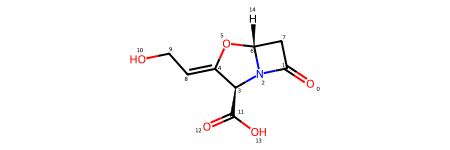

In [ ]:
IPythonConsole.drawOptions.addAtomIndices = True
clavulanic_acid

## Descriptors 

Molecular descriptors are numerical representations of chemical structures and properties. They can come from the molecular formula, the molecule's size and shape, or even its electronic structure. 

We're going to calculate some descriptors of some drug molecules, downloaded from the Chembl database (https://www.ebi.ac.uk/chembl/). This will be a great chance to practice all of those pandas skills you learned in week 4!

Read in the database. How many entries are there? How many columns? What data does it contain? (Note that the dataset has the separator ";" instead of ",").

In [8]:
import pandas as pd

drugs = pd.read_csv("chembl_drugs.csv", sep= ";")

print("Shape", drugs.shape)
print("Columns", drugs.columns)

Shape (14805, 29)
Columns Index(['Parent Molecule', 'Name', 'Synonyms', 'Research Codes', 'Phase',
       'Drug Applicants', 'USAN Stem', 'USAN Year', 'USAN Definition',
       'USAN Stem - Substem', 'First Approval', 'ATC Codes',
       'Level 4 ATC Codes', 'Level 3 ATC Codes', 'Level 2 ATC Codes',
       'Level 1 ATC Codes', 'Indication Class', 'Patent', 'Drug Type',
       'Passes Rule of Five', 'First In Class', 'Chirality', 'Prodrug', 'Oral',
       'Parenteral', 'Topical', 'Black Box', 'Availability Type', 'Smiles'],
      dtype='object')


Filter this database for molecules that have `Phase = 4` and have an entry in the `Smiles` column that is not null. 

In [11]:
approved_drugs = drugs[(drugs["Phase"] == 4) & (drugs["Smiles"].notnull())]
print(approved_drugs)

      Parent Molecule               Name  \
2       CHEMBL1868702         GESTRINONE   
156     CHEMBL3707281  MAGNESIUM LACTATE   
170     CHEMBL3833409       HYDROTALCITE   
182      CHEMBL307145         PYROGALLOL   
373     CHEMBL2107004       QUINESTRADOL   
...               ...                ...   
14797    CHEMBL360328         LORCASERIN   
14799      CHEMBL1237         LISINOPRIL   
14800       CHEMBL563       FLURBIPROFEN   
14801      CHEMBL1115     PYRIDOSTIGMINE   
14804      CHEMBL1457        HYDROCODONE   

                                                Synonyms  \
2      A 46 745|A-46-745|A-46745|DIMETRIOSE|GESTRINON...   
156    ANHYDROUS MAGNESIUM LACTATE, DL-|DL-LACTIC ACI...   
170                                         HYDROTALCITE   
182                  NSC-5035|PYROGALLIC ACID|PYROGALLOL   
373         COLPOVIS|PENTOVIS|QUINESTRADIOL|QUINESTRADOL   
...                                                  ...   
14797                                         LORCA

We're also going to filter for compounds without a "." in the smiles. The "." denotes separate molecules, often salts, and it will be nicer to get rid of them. 

In [ ]:
approved_drugs = approved_drugs[~approved_drugs["Smiles"].str.contains("\.")]
approved_drugs.reset_index(inplace = True, drop = True)

Let's take a look at our dataset. Although smiles are relatively human-readable, it would be nice to see the structure. We can use the PandasTools module to help. 

In [ ]:
from rdkit.Chem import PandasTools

PandasTools.RenderImagesInAllDataFrames(images = True) # needed to render images if you run the cell multiple times

PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol = "Smiles", molCol = "RdkitMOL")

/Users/skopf/miniconda3/envs/ppchem/lib/python3.10/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,...,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles,RdkitMOL
0,CHEMBL1868702,GESTRINONE,A 46 745|A-46-745|A-46745|DIMETRIOSE|GESTRINON...,A 46 745|A-46-745|A-46745|R 2323|R-2323|RU 232...,4.0,NaN,'-estr-; -rinone',1978.0,estrogens; cardiotonics (amrinone type),'-estr-(-estr-); -rinone(-rinone)',...,0,Single Stereoisomer,0,0,0,0,0,Unknown,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...,
1,CHEMBL307145,PYROGALLOL,NSC-5035|PYROGALLIC ACID|PYROGALLOL,NSC-5035,4.0,NaN,NaN,NaN,NaN,NaN,...,0,Achiral Molecule,0,0,0,0,0,Unknown,Oc1cccc(O)c1O,

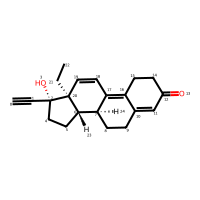
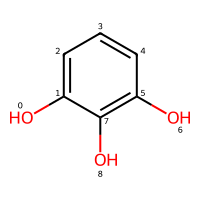

In [ ]:
approved_drugs.head(2)

We can also do this by ourselves by adding a molecule column to the dataframe. 

In [18]:
approved_drugs["My_Mol"] = approved_drugs["Smiles"].apply(Chem.MolFromSmiles)
approved_drugs.head(2)

[11:00:18] WARNING: not removing hydrogen atom without neighbors
[11:00:18] WARNING: not removing hydrogen atom without neighbors
[11:00:18] WARNING: not removing hydrogen atom without neighbors
[11:00:18] WARNING: not removing hydrogen atom without neighbors
C:\Users\33783\AppData\Local\Temp\ipykernel_62184\3395481691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved_drugs["My_Mol"] = approved_drugs["Smiles"].apply(Chem.MolFromSmiles)


,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,...,Black Box,Availability Type,Smiles,NumRotatableBonds,NumHDonors,NumHAcceptors,MolWt,MolLogP,NumValenceElectrons,My_Mol
2,CHEMBL1868702,GESTRINONE,A 46 745|A-46-745|A-46745|DIMETRIOSE|GESTRINON...,A 46 745|A-46-745|A-46745|R 2323|R-2323|RU 232...,4.0,NaN,'-estr-; -rinone',1978.0,estrogens; cardiotonics (amrinone type),'-estr-(-estr-); -rinone(-rinone)',...,0,Unknown,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...,1,1,2,308.421,3.7228,120,<rdkit.Chem.rdchem.Mol object at 0x00000129F03...
156,CHEMBL3707281,MAGNESIUM LACTATE,"ANHYDROUS MAGNESIUM LACTATE, DL-|DL-LACTIC ACI...",NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,0,Unknown,CC(O)C(=O)[O-].CC(O)C(=O)[O-].[Mg+2],2,2,6,202.445,-4.1466,72,<rdkit.Chem.rdchem.Mol object at 0x00000129F03...


Note that we are storing rdkit mol objects, which are rendered into images when displayed. 

Number of atoms:  23


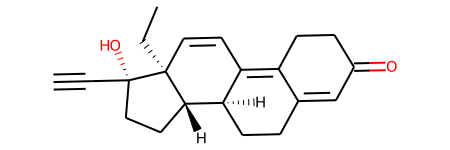

In [19]:
print("Number of atoms: ", approved_drugs["My_Mol"].iloc[0].GetNumAtoms())
approved_drugs["My_Mol"].iloc[0]

If we have many many molecules, it may not make sense to store that many Mol objects in memory. Instead, we may want to perform a task on the fly, getting the data we need without keeping all of those mol objects. 

In [16]:
# Use stored Mol objects 
approved_drugs["n_atoms"] = approved_drugs["My_Mol"].apply(lambda x: x.GetNumAtoms())

# Use smiles directly, wihtout storing Mol Objects
approved_drugs["n_atoms_from_smiles"] = approved_drugs["Smiles"].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())

KeyError: 'My_Mol'

Use the Descriptors module in rdkit that you learned about in the lecture to calculate some properties of these molecules. Specifically, use the on-the-fly method to create new columns in the dataframe for `NumRotatableBonds`, `NumHDonors`, `NumHAcceptors`, `MolWt`, the `MolLogP` and `NumValenceElectrons`. 

In [7]:
from rdkit.Chem import Descriptors
approved_drugs["NumRotatableBonds"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
approved_drugs["NumHDonors"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
approved_drugs["NumHAcceptors"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))    
approved_drugs["MolWt"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
approved_drugs["MolLogP"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))
approved_drugs["NumValenceElectrons"] = approved_drugs["Smiles"].apply(lambda x: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(x)))

NameError: name 'approved_drugs' is not defined

Now, use the mordred library to find the number of F, Cl, Br, and I atoms in each molecule. Make a column for each. Sum these values together to get the total number of halogens (mordred calculates this but use your pandas skills here)

In [ ]:
#!pip install mordred

In [13]:
from mordred import Calculator, AtomCount

# Only calculate AtomCount descriptors
calc = Calculator(AtomCount, ignore_3D = True)

# Apply the calculator to the molecules 
mordred_df = calc.pandas(approved_drugs["My_Mol"])


# Only extract the number of halogens 
approved_drugs = pd.concat([approved_drugs, mordred_df[["nF", "nBr", "nCl", "nI"]]], axis = 1)

# Add the total number of halogens
approved_drugs["nX"] = approved_drugs[["nF", "nBr", "nCl", "nI"]].sum(axis = 1)

KeyError: 'My_Mol'

Make a histogram of the number of halogens that appear in drugs. 

In [ ]:
import matplotlib.pyplot as plt
approved_drugs.nX.hist(bins = 20)
plt.xlabel("Number of Halogens")
plt.ylabel("Frequency")
plt.title("Distribution of Halogens in Approved Drugs")

Rdkit comes with some convenient methods to visualize many molecules at once. 
Draw the top 10 molecules with the most halogens and label with their names and the number of halogens they contain. 

In [14]:
from rdkit.Chem import Draw
approved_drugs.sort_values("nX", ascending = False).head(10)
top_10_mols = top_10["My_Mol"].tolist()
top_10_names = top_10["Name"].tolist()
counts = top_10["nX"].tolist()

labels = [f"{name} - {count}" for name, count in zip(top_10_names, counts)]

Draw.MolsToGridImage(top_10_mols, molsPerRow=5, subImgSize=(300, 300), legends=labels)

KeyError: 'nX'

## Fingerprints and similarity search

We are going to use fingerprints to do a common task in cheminformatics: similarity search. Let's find the compound in this database most similar to tylenol (also called paracetamol, an over-the-counter pain medication). To do this, we need to create fingerprints for every compound in the database. We'll then compare each fingerprint with that of tylenol, and find which ones have a maximum tanimoto similarity. 

Step 1 in this process is to generate fingerprints for each molecule in the database. For now, let's use a Morgan fingerprint with a radius of 4 and a size of 2048. Let's use the bit vector version. 

In [21]:
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

mfp = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 2048)

approved_drugs["MorganFP"] = approved_drugs["My_Mol"].apply(lambda x: mfp.GetFingerprint(x))

C:\Users\33783\AppData\Local\Temp\ipykernel_62184\3952085235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved_drugs["MorganFP"] = approved_drugs["My_Mol"].apply(lambda x: mfp.GetFingerprint(x))


Now find the tylenol's fingerprint. Find the tanimoto similarity between tylenol and each molecule. Look at the top 5 most similar molecules. 

In [22]:
# Get tylenol's fingerprint
tylenol_fp = mfp.GetFingerprint(tylenol)

# Calculate the similarity to tylenol
approved_drugs["similarity_to_tylenol"] = approved_drugs["MorganFP"].apply(lambda x: Chem.DataStructs.TanimotoSimilarity(x, tylenol_fp))

approved_drugs.sort_values("similarity_to_tylenol", ascending = False).head(5)[["Name", "My_Mol", "similarity_to_tylenol"]]

NameError: name 'tylenol' is not defined

Great! Our most similar molecule is actually tylenol (also called acetaminophen). Lets compare the morgan fingerprint to the other fingerprints you learned about in the lecture, namely the rdkit, atom pair, and topological torsion fingerprints. Repeat the above procedure for each type of fingerprint, again examining the top 5 molecules. 

/Users/skopf/miniconda3/envs/ppchem/lib/python3.10/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Name,My_Mol,similarity_to_tylenol
865,ACETAMINOPHEN,,1.000000
512,PHENACETIN,,0.533333
789,BUCETIN,,0.300000
1314,PRACTOLOL,,0.400000
1106,VORINOSTAT,,0.270270

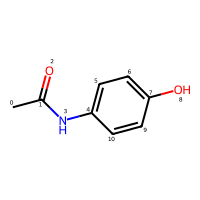
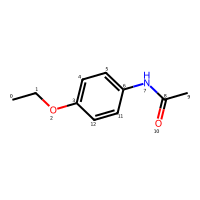
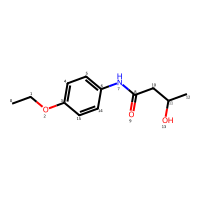
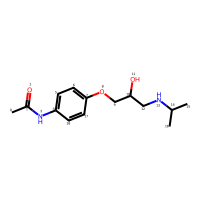
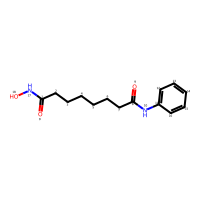

In [ ]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
approved_drugs["RDKitFP"] = approved_drugs["My_Mol"].apply(lambda x: rdkgen.GetFingerprint(x))

# Get tylenol's fingerprint
tylenol_fp_rdk = rdkgen.GetFingerprint(tylenol)
approved_drugs["similarity_to_tylenol_rdk"] = approved_drugs["RDKitFP"].apply(lambda x: Chem.DataStructs.TanimotoSimilarity(x, tylenol_fp_rdk))
approved_drugs.sort_values("similarity_to_tylenol_rdk", ascending = False).head(5)[["Name", "My_Mol", "similarity_to_tylenol"]]

/Users/skopf/miniconda3/envs/ppchem/lib/python3.10/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Name,My_Mol,similarity_to_tylenol
865,ACETAMINOPHEN,,1.000000
512,PHENACETIN,,0.533333
1489,ACETARSONE,,0.361111
1613,MENADIONE,,0.138889
1949,METHYL SALICYLATE,,0.272727
789,BUCETIN,,0.300000
285,IBUFENAC,,0.194444
221,HYDROXYAMPHETAMINE,,0.281250
169,MEFENAMIC ACID,,0.195122
1749,DIAZOXIDE,,0.111111

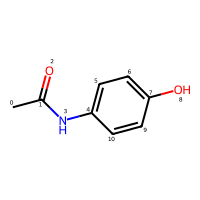
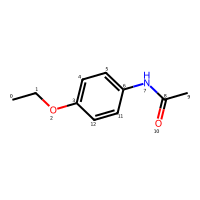
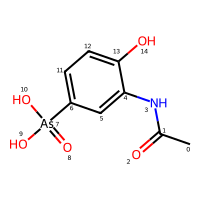
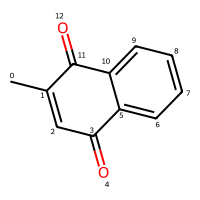
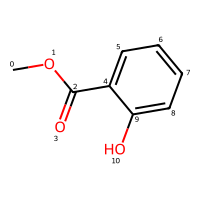
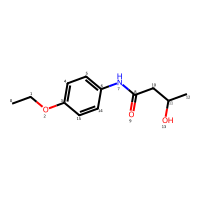
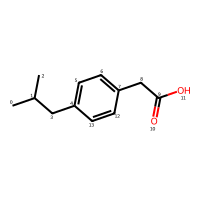
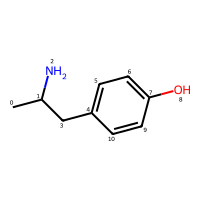
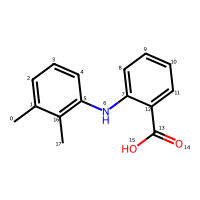
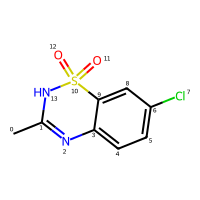

In [ ]:
atom_pairs = rdFingerprintGenerator.GetAtomPairGenerator(fpSize = 2048)
approved_drugs["AtomPairFP"] = approved_drugs["My_Mol"].apply(lambda x: atom_pairs.GetFingerprint(x))

# Get tylenol's fingerprint
tylenol_fp_ap = atom_pairs.GetFingerprint(tylenol)
approved_drugs["similarity_to_tylenol_ap"] = approved_drugs["AtomPairFP"].apply(lambda x: Chem.DataStructs.TanimotoSimilarity(x, tylenol_fp_ap))


approved_drugs.sort_values("similarity_to_tylenol_ap", ascending = False).head(10)[["Name", "My_Mol", "similarity_to_tylenol"]]

/Users/skopf/miniconda3/envs/ppchem/lib/python3.10/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Name,My_Mol,similarity_to_tylenol
865,ACETAMINOPHEN,,1.000000
512,PHENACETIN,,0.533333
269,HYDROQUINONE,,0.400000
221,HYDROXYAMPHETAMINE,,0.281250
1314,PRACTOLOL,,0.400000

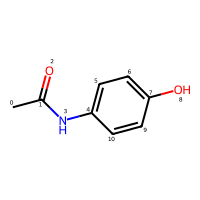
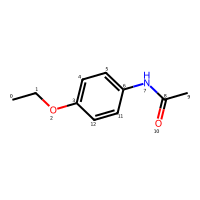
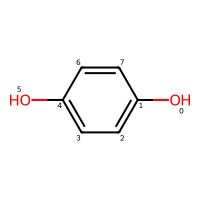
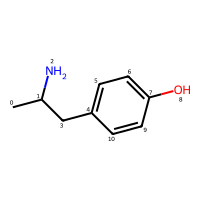
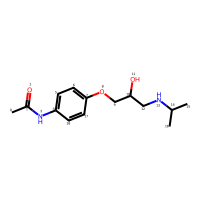

In [ ]:
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize = 2048)
approved_drugs["TopologicalTorsionFP"] = approved_drugs["My_Mol"].apply(lambda x: ttgen.GetFingerprint(x))

# Get tylenol's fingerprint
tylenol_fp_tt = ttgen.GetFingerprint(tylenol)
approved_drugs["similarity_to_tylenol_tt"] = approved_drugs["TopologicalTorsionFP"].apply(lambda x: Chem.DataStructs.TanimotoSimilarity(x, tylenol_fp_tt))

# Draw the top 10
approved_drugs.sort_values("similarity_to_tylenol_tt", ascending = False).head(5)[["Name", "My_Mol", "similarity_to_tylenol"]]

Similarity search is indeed sensitive to fingerprint choice. Pick yours depending on your specific application! 

## Challenge problem: 

You can change the highlight color on atoms! To do so, set the `highlightAtomColors` parameter within the `Draw.MolsToGridImage()` to a dictionary with the form {atom_index: color}, where color is a tuple of three numbers between 0 and 1 (e.g. (0.3, 0.3, 0.1))

Draw the top 10 halogenated molecules, but highlight each halogen in a different color. 

In [23]:
# highlight each halogen
halogens = ["F", "Br", "Cl", "I"]
highlights = []
colors = []
for mol in top_10_mols:
    highlight = []
    color = {}
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in halogens:
            highlight.append(atom.GetIdx())
        if atom.GetSymbol() == "F":
            color[atom.GetIdx()] = (0.8,0,0.8)
        elif atom.GetSymbol() == "Br":
            color[atom.GetIdx()] = (0.8,0.8,0)
        elif atom.GetSymbol() == "Cl":
            color[atom.GetIdx()] = (0,0.8,0.8)
        elif atom.GetSymbol() == "I":
            color[atom.GetIdx()] = (0.8,0,0)


    highlights.append(highlight)
    colors.append(color)



Draw.MolsToGridImage(top_10_mols, molsPerRow=5, subImgSize=(300, 300), highlightAtomLists=highlights, highlightAtomColors = colors, legends=labels)

NameError: name 'top_10_mols' is not defined